In [1]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models

import pandas as pd
import numpy as np
import os
import time

Order for Loading Data
1. Import necessary Libraries
2. Import Data
3. Write or instantiate Dataset object--some for image, some for sound, csv etc
4. Pass instantiated object into dataloader

In [4]:
#Import
#! consol command
#-q quiet, suppresses output
#!unzip -q "/content/drive/MyDrive/CS577_Project/dataset.zip"
!unzip -q "archive (7).zip"

In [ ]:
#Class to represent Data Set--subclass of imported dataset class
class EmotionDataset(Dataset):
  #Static declaration
  #Surprise entered as suprise in dataset
  classes=["Angry","Fear","Happy","Neutral","Sad","Suprise"]
  numclasses=6

  #Pass in path to inner testing training folders--use parameter "root"
  def __init__(self, root):
    super().__init__()
    self.root=root
    #Instance variable lists--file paths, lables, loops-can be overwritten for specific instance see self.classes
    self.filepath=[]
    self.filelabel=[]
    for index, label in enumerate(self.classes):
      #Joins multiple path commponents into one, agnostic to OS
      labeldatapath=os.path.join(root,label)
      #Return list of files and directories in called folder
      filenames=os.listdir(labeldatapath)
      #Path from current directory to file--join labeldatapath with file name
      #Without List Comprehension
      #for filename in filenames:
          #Construct full relative path
          #self.filepath.append(os.path.join(labeldatapath,filename))
          #Append index so classes have numbers
          #self.filelabel.append(index)
          #With List Comprehension
    self.filepath+=[os.path.join(labeldatapath,filename) for filename in filenames]
    self.filelabel+=[index]*len(filenames)

  def __getitem__(self, index):
    return torchvision.io.read_image(self.filepath[index]),torch.tensor(self.filelabel[index])
  def __len__(self):
    return len(self.filepath)

In [ ]:
#Instantiate Train and Test DataSets then feed into DataLoader
#Root Directory at the Splits Builds INdex
training_ds=EmotionDataset("Training/Training")
testing_ds=EmotionDataset("Testing/Testing")

train_dataloader=DataLoader(training_ds, batch_size=4,shuffle=True)
testing_dataloader=DataLoader(testing_ds, batch_size=4,shuffle=False)

for images,labels in train_dataloader:
  print(images.size())
  print(labels.size())
  break

torch.Size([4, 1, 48, 48])
torch.Size([4])


In [ ]:
#Transformer(Encoder-Decoder) model which acts as a pretrained model for transfer learning in channel boosting technique.
class Transformer_TL(nn.Module):
  def __init__(self):
    super(Transformer_TL, self).__init__()

    #Encoder.
    self.encoder = nn.Sequential(
      nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
      nn.ReLU(True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(True),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

    #Decoder.
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.ReLU(True),
      nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.Sigmoid()
    )

  #Forward Pass.
  def forward(self, x):
    x = self.encoder(x)

    x = self.decoder(x)

    return x

In [ ]:
#CNN with a pre-trained model (ResNet) for transfer learning in channel boosting.
class CNN_ResNet(nn.Module):
  def __init__(self, encoder_decoder):
    super(CNN_ResNet, self).__init__()
    self.encoder_decoder = encoder_decoder
    self.resnet = models.resnet18(pretrained=True)
    self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.resnet.fc = nn.Identity()

  def forward(self, x):
    x = self.encoder_decoder(x)
    x = self.resnet(x)
    return x

In [ ]:
#Model instantiation.
transformer_instance = Transformer_TL()

channel_boosted_CNN = CNN_ResNet(transformer_instance)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(channel_boosted_CNN.parameters(), lr=0.001)

#Training loop.
num_epochs = 10
train_losses = []
train_accuracies = []
for epoch in range(num_epochs):
  running_loss = 0.0
  correct = 0
  total = 0
  channel_boosted_CNN.train()
  for images, labels in train_dataloader:
    optimizer.zero_grad()
    images = torch.tensor(images, dtype=torch.float32)
    outputs = channel_boosted_CNN(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    #Loss.
    running_loss += loss.item()

    #Accuracy.
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  train_loss = running_loss / len(train_dataloader)
  train_acc = 100 * correct / total
  train_losses.append(train_loss)
  train_accuracies.append(train_acc)

  print(f"Epoch [{epoch + 1}/{num_epochs}] Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")

#Testing loop.
test_losses = []
test_accuracies = []
channel_boosted_CNN.eval()
with torch.no_grad():
  test_loss = 0.0
  for images, labels in testing_dataloader:
    outputs = channel_boosted_CNN(images.float())
    loss = criterion(outputs, labels)

    #Loss.
    test_losses.append(loss.item())

    #Accuracy.
    _, predicted = torch.max(outputs, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    test_accuracies.append(test_acc)

avg_test_loss = sum(test_losses) / len(test_losses)
avg_test_acc = sum(test_accuracies) / len(test_accuracies)
print(f"Average Test Loss: {avg_test_loss:.4f}, Average Test Accuracy: {avg_test_acc:.2f}%")

<ipython-input-13-bfe6f27da645>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images, dtype=torch.float32)


Epoch [1/10] Training Loss: 4.2468, Training Accuracy: 79.25%
Epoch [2/10] Training Loss: 1.2803, Training Accuracy: 100.00%
Epoch [3/10] Training Loss: 0.3078, Training Accuracy: 100.00%
Epoch [4/10] Training Loss: 0.1200, Training Accuracy: 100.00%
Epoch [5/10] Training Loss: 0.0604, Training Accuracy: 100.00%
Epoch [6/10] Training Loss: 0.0343, Training Accuracy: 100.00%
Epoch [7/10] Training Loss: 0.0208, Training Accuracy: 100.00%
Epoch [8/10] Training Loss: 0.0132, Training Accuracy: 100.00%
Epoch [9/10] Training Loss: 0.0085, Training Accuracy: 100.00%
Epoch [10/10] Training Loss: 0.0056, Training Accuracy: 100.00%
Average Test Loss: 0.0063, Average Test Accuracy: 100.00%


<Figure size 640x480 with 0 Axes>

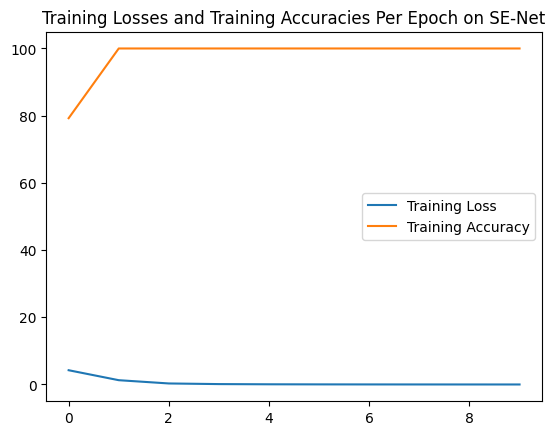

<Figure size 640x480 with 0 Axes>

In [ ]:
from matplotlib import pyplot as plt

plt.title("Training Losses and Training Accuracies Per Epoch on SE-Net")
plt.plot(train_losses)
plt.plot(train_accuracies)
plt.legend(['Training Loss','Training Accuracy'],loc=5)
plt.figure()